# 1D Layered Earth model using `SimPEG`



In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time
from datetime import datetime

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
import SimPEG
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

## load the model and survey

In [2]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

In [3]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [4]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z']
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


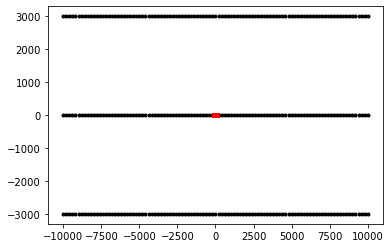

In [5]:
plt.plot(rx_locs[:,0], rx_locs[:,1], 'k. ')
plt.plot(src[:2], np.zeros(2), 'r-', lw=5)


In [6]:
np.unique(res1d)

array([3.e-01, 1.e+00, 2.e+00, 1.e+03, 1.e+08])

In [7]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(res1d))}"
)

skin depth: [2.75504446e+02 5.03000000e+02 7.11349422e+02 1.59062566e+04
 5.03000000e+06]


## create a computational mesh

Start by defining the underlying tensor mesh

In [8]:
dx, dy, dz = 100, 200, 50 
domain_x, domain_y, domain_z = 2e4, 6e3, np.abs(depth).max()

ncore_x = domain_x/dx
ncore_y = domain_y/dy
ncore_z = domain_z/dz

# print(ncore_x, ncore_y, ncore_z, ncore_x*ncore_y*ncore_z)

# npad_x = 18
# npad_y = 16
# npad_z = 20

# ncx = 2**int(np.ceil(np.log(ncore_x + npad_x*2)/np.log(2.)))
# ncy = 2*2**int(np.ceil(np.log(ncore_y + npad_y*2)/np.log(2.)))
# ncz = 2**int(np.ceil(np.log(ncore_z + npad_z*2)/np.log(2.)))

# print(ncx, ncy, ncz, ncx*ncy*ncz)

# pf = 1.35
# pfz = 1.35

In [45]:
pad_x = 20000
pad_y = 20000
pad_z = 20000

length_x = pad_x * 2 + domain_x
length_y = pad_y * 2 + domain_y
length_z = pad_z * 2 + domain_z

nx = int(length_x/dx)
ny = int(length_y/dy)
nz = int(length_z/dz)

nx = 2**int(np.ceil(np.log(nx)/np.log(2.)))
ny = 2**int(np.ceil(np.log(ny)/np.log(2.)))
nz = 2**int(np.ceil(np.log(nz)/np.log(2.)))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy
hz = np.ones(nz) * dz
mesh_b = discretize.TreeMesh(
    [hx, hy, hz], x0=[-hx.sum()/2-dx/2., -hy.sum()/2, -hz.sum()/2.]
)

# refine around the layers 
for i_layer, d in enumerate(depth[:3]):     
    xrefine = domain_x*2*np.r_[-1, 1]
    yrefine = domain_x*1.5*np.r_[-1, 1]    
        
    xr, yr, zr = np.meshgrid(xrefine, yrefine, np.r_[d])
    surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
    mesh_b = discretize.utils.refine_tree_xyz(
        mesh_b, surface_refine, 
        octree_levels=[0, 0, 1], method="surface", finalize=False
    )
# refine around the sources and receivers
xr, yr, zr = np.meshgrid(src[0:2], src[2] + dy/2*np.r_[-1, 1], src[4] + dz/2*np.r_[-1, 1]) 
src_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
mesh_b = discretize.utils.refine_tree_xyz(
    mesh_b, src_refine, 
    octree_levels=[4, 4, 2, 2], method="box", finalize=False
)

mesh_b = discretize.utils.refine_tree_xyz(
    mesh_b, rx_locs, 
    octree_levels=[8, 4, 2, 2], method="radial", finalize=False
)
mesh_b.finalize()

### create the octree mesh

In [46]:
def plot_mesh(normal="Y", ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100):
    fig, ax = plt.subplots(1, 1)
    mesh_b.plotSlice(np.log10(mesh_b.vol), normal=normal, grid=True, ax=ax, ind=ind)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [47]:
max_h = np.max([len(h) for h in mesh_b.h])
ipywidgets.interact(
    plot_mesh,
    normal=ipywidgets.ToggleButtons(options=["X", "Y", "Z"], value="Y"),
    ind=ipywidgets.IntSlider(min=0, max=max_h, value=int(len(mesh_b.h[1])/2)),
    xmin=ipywidgets.FloatText(value=-domain_x),
    xmax=ipywidgets.FloatText(value=domain_x),
    ymin=ipywidgets.FloatText(value=-4000),
    ymax=ipywidgets.FloatText(value=100)
)

interactive(children=(ToggleButtons(description='normal', index=1, options=('X', 'Y', 'Z'), value='Y'), IntSli…

<function __main__.plot_mesh(normal='Y', ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100)>

### put the model on the computational mesh

In [48]:
len(mesh_b.h[0])

1024

In [49]:
mesh_tensor = discretize.TensorMesh(
    [
        [(dx, nx)], 
        [(dy, ny)], 
        [(dz, nz)]
    ]
)
mesh_tensor.x0 = np.r_[-np.sum(mesh_tensor.h[0])/2., -np.sum(mesh_tensor.h[1])/2., -5000.]
rho_z_h = np.ones(mesh_tensor.nC) * 1e8
rho_z_v = np.ones(mesh_tensor.nC) * 1e8
depth_new = np.r_[np.array(depth), -np.Inf]
z = mesh_tensor.gridCC[:,2]
for ii in range(4):
    inds = np.logical_and(z<depth_new[ii], z>depth_new[ii+1])
    rho_z_h[inds] = res1d[ii+1]
    rho_z_v[inds] = res1d[ii+1] * aniso[ii+1]**2

In [50]:
# Use volume averaging in log space
from discretize.utils.interputils import volume_average
rhoh_b = np.exp(volume_average(mesh_tensor, mesh_b, np.log(rho_z_h)))
rhov_b = np.exp(volume_average(mesh_tensor, mesh_b, np.log(rho_z_v)))

In [51]:
# mesh_emg3d = discretize.TensorMesh.readUBC("mesh_tensor")
# rhoh_emg3d = mesh_emg3d.readModelUBC("rhoh.mod")

In [52]:
# mesh_emg3d.write_vtk("emg3d.vtr", models={'rhoh':rhoh_emg3d})

In [53]:
mesh_b

OcTreeMesh,0.10% filled
Level,Number of cells
1,2
2,56
3,252
4,824
5,3084
6,11736
7,81236
8,52644
9,118240


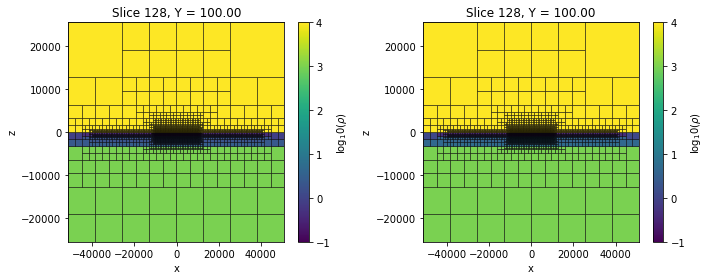

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for a, m, mesh in zip(
    ax.flatten(), 
    [rhoh_b, rhov_b], #rhoh_t, rhov_t], 
    [mesh_b, mesh_b], #mesh_t, mesh_t]
):
    cb = plt.colorbar(
        mesh.plotSlice(
            np.log10(m), ax=a, normal='Y', 
            pcolorOpts={"vmin":-1, "vmax":4}, grid=True
        )[0],ax=a)
    cb.set_label("log$_10$($\\rho$)")
#     a.set_xlim(10*domain_x*np.r_[-1, 1])
#     a.set_ylim([-4000, 100])

plt.tight_layout()

In [55]:
rho_b = np.vstack([rhoh_b, rhoh_b, rhov_b]).T

## set up the frequency domain simulation

In [56]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [57]:
def build_source(mesh): 
    src_x = np.zeros(mesh.nEx)
    src_inds = (
        (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
        (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
        (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
    )
    src_x[src_inds] = 1
    print(src_inds.nonzero())

    src_vec = strength * mesh.edge * np.hstack([
        src_x, np.zeros(mesh.nEy), np.zeros(mesh.nEz)
    ])
    source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])
    
    return source

In [58]:
source_b = build_source(mesh_b)

(array([109942, 110389, 111280]),)


In [59]:
survey_b = fdem.Survey([source_b])

In [60]:
sim_b = fdem.Simulation3DElectricField(
    mesh=mesh_b, solver=Pardiso, survey=survey_b, rho=rho_b
)

In [61]:
%%time
t0 = time.time()
mem_b = %memit -o fields_b = sim_b.fields()
time_b = time.time()-t0
ram_b = f"{(mem_b.mem_usage[0] - mem_b.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_b}")

peak memory: 7145.43 MiB, increment: 1281.20 MiB
memory usage: 1.251 GiB
CPU times: user 13min 31s, sys: 4min 6s, total: 17min 37s
Wall time: 13min 57s


In [62]:
from scipy import interpolate

In [63]:
# n_data_locs = rx_re.locs.shape[0]
# data_re_rbf = np.zeros(n_data_locs)
# data_im_rbf = np.zeros(n_data_locs)

# ncells_interp = 4 
# dx_interp = ncells_interp * dx
# dy_interp = ncells_interp * dy
# dz_interp = ncells_interp * dz

# ex = fields_b[:, "e"][:mesh_b.nEx]

# for i in range(n_data_locs):
#     inds = (
#         (mesh_b.gridEx[:, 0] >= rx_re.locs[i, 0] - dx_interp) & 
#         (mesh_b.gridEx[:, 0] <= rx_re.locs[i, 0] + dx_interp) &
#         (mesh_b.gridEx[:, 1] >= rx_re.locs[i, 1] - dy_interp) & 
#         (mesh_b.gridEx[:, 1] <= rx_re.locs[i, 1] + dy_interp) &
#         (mesh_b.gridEx[:, 2] >= rx_re.locs[i, 2] - dz_interp) & 
#         (mesh_b.gridEx[:, 2] <= rx_re.locs[i, 2] + dz_interp) 
#     )
    
#     grid = mesh_b.gridEx[inds, :]
#     ex_re = ex[inds].real
#     ex_im = ex[inds].imag
    
#     rbf_re = interpolate.Rbf(grid[:, 0], grid[:, 1], grid[:, 2], ex_re) #, function="cubic")
#     rbf_im = interpolate.Rbf(grid[:, 0], grid[:, 1], grid[:, 2], ex_im) #, function="cubic")
    
#     data_re_rbf[i] = rbf_re(rx_re.locs[i, 0], rx_re.locs[i, 1], rx_re.locs[i, 2])
#     data_im_rbf[i] = rbf_im(rx_re.locs[i, 0], rx_re.locs[i, 1], rx_re.locs[i, 2])
# d_b_rbf = np.hstack([data_re_rbf, data_im_rbf])    

In [64]:
d_b = sim_b.dpred(f=fields_b)  # this uses linear interpolation 

In [73]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = 1/1.5*np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = 1/1.5*np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = 1/1.5*np.vstack([d_re[202:], d_im[202:]]).T
    
    return [d_line1, d_line2, d_line3]

data_b_lines = get_data_lines(d_b)

In [74]:
# data_b_lines_rbf = get_data_lines(d_b_rbf)
# data_b_lines_rbf = data_b_lines.copy()

In [75]:
ex = fields_b[source_b, 'e'][:mesh_b.nEx]

In [76]:
ex_r_cc = mesh_b.aveEx2CC * ex.real
ex_i_cc = mesh_b.aveEx2CC * ex.imag

In [77]:
# mesh_b.write_vtk(
#     "csem.vtu", 
#     models={'rhoh':rhoh_b, 'rhov':rhov_b, 'ex_r':abs(ex_r_cc), 'ex_i':abs(ex_i_cc)}
# )


In [78]:
def extract_lines(name):
    import xarray as xr
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

epm_1d = extract_lines('../results/layered_empymod.nc')

In [79]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [80]:
# Calculate error
error = {}
spg_data = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_b_lines]).T

# spg_data = np.vstack(data_back_lines).T
for name, data in zip(['SimPEG'], [spg_data]):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

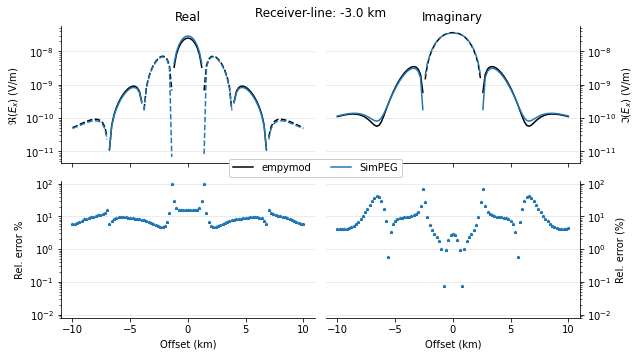

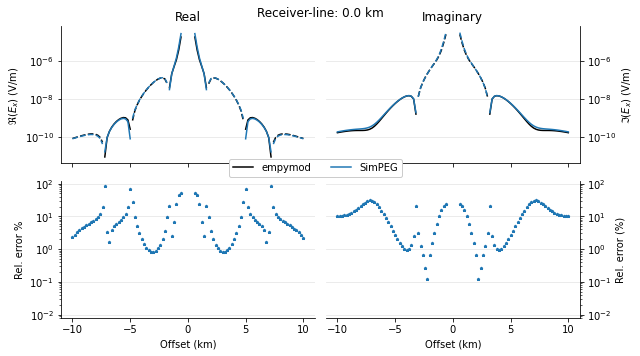

In [81]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C0-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C0--', ms=3)


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    plt.plot(0, -1, 'k', label='empymod')
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}', label=name)
        
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
    plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.legend(loc=2, ncol=2, bbox_to_anchor=(-0.4, 1.2), framealpha=1)
    
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

In [82]:
# import pyvista as pv

In [83]:
# tmp = pv.PolyData(rx_locs)

In [84]:
# tmp.save("pts.vtk")

In [85]:
for i in range(3):
    print(f"Line {i}")
    inds = ~ np.isnan(error['SimPEG'][:, i])
    print(f"mean real: {np.mean(error['SimPEG'][inds, i].real):1.2f}, imag: {np.mean(error['SimPEG'][inds, i].imag):1.2f}")
    print(f"median  real: {np.median(error['SimPEG'][inds, i].real):1.2f}, imag: {np.median(error['SimPEG'][inds, i].imag):1.2f}")             
    print("\n")
                  

Line 0
mean real: 11.34, imag: 11.79
median  real: 8.82, imag: 7.32


Line 1
mean real: 11.36, imag: 11.00
median  real: 5.19, imag: 10.38


Line 2
mean real: 11.34, imag: 11.79
median  real: 8.82, imag: 7.32




In [ ]:
# save_results = True

In [ ]:
# if save_results: 
#     # Save the three lines
#     ds.line_1.data = np.vstack([spg_data[:, 0].real, spg_data[:, 0].imag]).ravel('F')
#     ds.line_2.data = np.vstack([spg_data[:, 1].real, spg_data[:, 1].imag]).ravel('F')
#     ds.line_3.data = np.vstack([spg_data[:, 2].real, spg_data[:, 2].imag]).ravel('F')

#     # Add info
#     ds.attrs['runtime'] = time_b
#     ds.attrs['n_procs'] = 1
#     ds.attrs['max_ram'] = ram_b
#     ds.attrs['n_cells'] = f"{mesh_b.nC}"
#     ds.attrs['n_nodes'] = 'N/A'
#     ds.attrs['n_dof'] = f"{mesh.nE}"
#     ds.attrs['extent'] = (f"x = {mesh_b.vectorNx[0]:.1f}-{mesh_b.vectorNx[-1]:.1f}; " # Total mesh extent
#                           f"y = {mesh_b.vectorNy[0]:.1f}-{mesh_b.vectorNy[-1]:.1f}; "
#                           f"z = {mesh_b.vectorNz[0]:.1f}-{mesh_b.vectorNz[-1]:.1f}")
#     ds.attrs['min_vol'] = f"{np.min(mesh_b.vol):.1f}"
#     ds.attrs['max_vol'] = f"{np.max(mesh_b.vol):.1f}"
#     ds.attrs['machine'] = "GKE e2-highmem-16; Intel(R) Xeon(R) CPU @ 2.20GHz; 64GB RAM"
#     ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
#     ds.attrs['date'] = datetime.today().isoformat()

#     # Save it under <{model}_{code}.nc>
#     ds.to_netcdf(f"../results/layered_simpeg.nc", engine='h5netcdf')

In [ ]:
# # Save the three lines
# ds.line_1.data = np.vstack([spg_data_t[:, 0].real, spg_data_t[:, 0].imag]).ravel('F')
# ds.line_2.data = np.vstack([spg_data_t[:, 1].real, spg_data_t[:, 1].imag]).ravel('F')
# ds.line_3.data = np.vstack([spg_data_t[:, 2].real, spg_data_t[:, 2].imag]).ravel('F')

# # Add info
# ds.attrs['runtime'] = time_t
# ds.attrs['n_procs'] = 1
# ds.attrs['max_ram'] = ram_t
# ds.attrs['n_cells'] = f"{mesh_t.nC}"
# ds.attrs['n_nodes'] = 'N/A'
# ds.attrs['n_dof'] = f"{mesh.nE}"
# ds.attrs['extent'] = (f"x = {mesh_t.vectorNx[0]:.1f}-{mesh_t.vectorNx[-1]:.1f}; " # Total mesh extent
#                       f"y = {mesh_t.vectorNy[0]:.1f}-{mesh_t.vectorNy[-1]:.1f}; "
#                       f"z = {mesh_t.vectorNz[0]:.1f}-{mesh_t.vectorNz[-1]:.1f}")
# ds.attrs['min_vol'] = f"{np.min(mesh_t.vol):.1f}"
# ds.attrs['max_vol'] = f"{np.max(mesh_t.vol):.1f}"
# ds.attrs['machine'] = "Cheyenne Supercomputer - shared node; Intel(R) Xeon(R) CPU E5-2697 v4 @ 2.30GHz"
# ds.attrs['version'] = f"SimPEG v{SimPEG.__version__}"
# ds.attrs['date'] = datetime.today().isoformat()

# # Save it under <{model}_{code}.nc>
# ds.to_netcdf(f"../results/block_simpeg.nc", engine='h5netcdf')